# Transformers

## Overview

**This notebook implements Transformer model for HCP (movie watching) data**

Transformers were first present by Vaswani, et al. in their paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762).


---
## Data Organization
Same as in the [gru + attention](https://akshatyadav0.github.io/P_Lab_Works/attention_2.html) notebook

In [1]:
import torch
import pickle
import numpy as np
from ray import tune
import torch.nn as nn
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
with open('Data/HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)
print(TS.keys())

dict_keys(['testretest', 'twomen', 'bridgeville', 'pockets', 'overcome', 'inception', 'socialnet', 'oceans', 'flower', 'hotel', 'garden', 'dreary', 'homealone', 'brokovich', 'starwars'])


In [3]:
rel = {}
l = 0
seq_length = 0
time_changes = []
for movie_name, ts in TS.items():
    rel[movie_name] = l
    l += 1
    seq_length = max(seq_length, ts.shape[-2])
    time_changes.append(ts.shape[-2])
    print(movie_name, ts.shape)
time_changes = np.array(time_changes)
time = [i for i in range(1,seq_length+1)]

testretest (4, 176, 84, 300)
twomen (176, 245, 300)
bridgeville (176, 222, 300)
pockets (176, 189, 300)
overcome (176, 65, 300)
inception (176, 227, 300)
socialnet (176, 260, 300)
oceans (176, 250, 300)
flower (176, 181, 300)
hotel (176, 186, 300)
garden (176, 205, 300)
dreary (176, 143, 300)
homealone (176, 233, 300)
brokovich (176, 231, 300)
starwars (176, 256, 300)


In [4]:
train_feature = []
test_feature  = []
train_target  = []
test_target   = []

for movie_name, ts in TS.items():
    pep = 0
    if movie_name != "testretest":
        for i in ts:
            pep += 1
            if (pep <= 100):
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                    
                    k = i[i.shape[0]-seq_length:][:]
                    train_feature.append(k)
                    train_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[-1]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    train_feature.append(k)
                    k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                    train_target.append(k)
                else:
                    train_feature.append(i)
                    train_target.append([[rel[movie_name]] for _ in range(seq_length)])

            else:
                if i.shape[0]>seq_length:
                    k = i[:seq_length][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                   
                    k = i[i.shape[0]-seq_length:][:]
                    test_feature.append(k)
                    test_target.append(rel[movie_name])
                
                elif i.shape[0]<seq_length:
                    k = [[-1]*300]*seq_length
                    k[seq_length-i.shape[0]:] = i
                    test_feature.append(k)
                    k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                    test_target.append(k)
                else:
                    test_feature.append(i)
                    test_target.append([[rel[movie_name]] for _ in range(seq_length)])
        print(pep)
    else:
        for jj in ts:
            pep = 0
            for i in jj:
                pep += 1
                if (pep <= 106):
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        train_feature.append(k)
                        train_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[-1]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        train_feature.append(k)
                        k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                        train_target.append(k)
                    else:
                        train_feature.append(i)
                        train_target.append([[rel[movie_name]] for _ in range(seq_length)])

                else:
                    if i.shape[0]>seq_length:
                        k = i[:seq_length][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                        k = i[i.shape[0]-seq_length:][:]
                        test_feature.append(k)
                        test_target.append(rel[movie_name])

                    elif i.shape[0]<seq_length:
                        k = [[-1]*300]*seq_length
                        k[seq_length-i.shape[0]:] = i
                        test_feature.append(k)
                        k = [[rel[movie_name]] for _ in range(i.shape[0])] + [[-100] for _ in range(seq_length-i.shape[0])]
                        test_target.append(k)
                    else:
                        test_feature.append(i)
                        test_target.append([[rel[movie_name]]*15 for _ in range(seq_length)])
            print(pep)

176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176


In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(np.array(train_feature)).float(),torch.from_numpy(np.array(train_target)).float())
test_data  = TensorDataset(torch.from_numpy(np.array(test_feature)).float(),torch.from_numpy(np.array(test_target)).float())

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
valid_data  = 0.246
t_train     = len(train_data)
data_no     = list(range(t_train))
np.random.shuffle(data_no)
split_no    = int(valid_data*t_train)
train,valid = data_no[split_no:],data_no[:split_no]

train_sampler = SubsetRandomSampler(train)
valid_sampler = SubsetRandomSampler(valid)

train_loader  = DataLoader(train_data,batch_size=batch_size,sampler=train_sampler)#drop_last=True)
valid_loader  = DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size)#drop_last=True)
test_loader   = DataLoader(test_data, batch_size=batch_size,shuffle = True)

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

## Modelling

### Positional Encodings
<img src = "po_enc.png">

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,seq_len):
        """
        Args:
            seq_len: length of input sequence
            d_model: demension of encoding
        """
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        pe = torch.zeros(seq_len,self.d_model)
        
        for pos in range(seq_len):
            for i in range(0,self.d_model,2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i)/self.d_model)))
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1))/self.d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        x = x + torch.autograd.Variable(self.pe[:,:self.seq_len], requires_grad=False)
        return x

### Self Attention
<img src = "scale_dot_product_attention.jpg">

In [9]:
class Attention(nn.Module):
    """
    q : current sequence
    k : every sequence to check relationship with Qeury
    v : every seq same with Key
    """

    def __init__(self):
        super(Attention, self).__init__()
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):     # [batch_size, head, length, d_tensor]
        
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        
        k_t = k.transpose(2, 3)
        score = (q @ k_t) / np.sqrt(d_tensor)  # scaled dot product

        # 2. Masking (opt)
        
        # 3. Softmax
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

### Multi Head Attention
<img src = "multi_head_attention.jpg">

In [10]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = Attention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v)#, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)
        
        return out

    def split(self, tensor):
        """
        split tensor by number of head
        
        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)

        return tensor

    def concat(self, tensor):
        """
        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

### Feed Forward

In [11]:
class FeedForward(nn.Module):
    def __init__(self, d_model, feed_fwd, dropout):
        super().__init__() 
        
        self.l1 = nn.Linear(d_model, feed_fwd)
        self.l2 = nn.Linear(feed_fwd, d_model)
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.relu = nn.ReLU()
    def forward(self, x):
        
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

### Transformer Block

In [12]:
class TransformerBlock(nn.Module):
    
    def __init__(self, d_model,feed_fwd ,n_heads,drop_prob):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           n_heads: number of attention heads
        
        """
        
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.feed_fwd = FeedForward(d_model=d_model, feed_fwd=feed_fwd, dropout=drop_prob)

        self.dropout1 = nn.Dropout(p=drop_prob)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self,x):#key,query,value):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
        """
        
        # 1. compute self attention
        _x = x
        #print(x.shape)
        x = self.attention(q=x, k=x, v=x)
        
        # 2. add and norm
        x = self.norm1(x + _x)
        x = self.dropout1(x)
        
        # 3. feed forward network
        _x = x
        x = self.feed_fwd(x)
      
        # 4. add and norm
        x = self.norm2(x + _x)
        x = self.dropout2(x)
        
        return x

### Complied Model (No PoE)

In [13]:
class Transformer_Model(nn.Module):

    def __init__(self, d_model, feed_fwd, out_dim, n_layers, n_head, drop_prob):
        super(Transformer_Model, self).__init__()

        self.layers = nn.ModuleList([TransformerBlock(d_model, feed_fwd, n_head, drop_prob) for i in range(n_layers)])
        #nn.Transformer(d_model=300, nhead=4, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=1024, dropout=0.1)
        self.linear_out = nn.Linear(d_model,out_dim)
        self.fu = nn.Softmax(dim=-1)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.linear_out(x)
        return self.fu(x)

### Complied Model (with PoE)

In [14]:
class Transformer_Model_PoE(nn.Module):

    def __init__(self, d_model, feed_fwd, out_dim, n_layers, n_head, drop_prob):
        super(Transformer_Model_PoE, self).__init__()
        
        self.po_en = PositionalEncoding(d_model,seq_len=seq_length)
        self.layers = nn.ModuleList([TransformerBlock(d_model, feed_fwd, n_head, drop_prob) for i in range(n_layers)])
        self.linear_out = nn.Linear(d_model,out_dim)
        
    def forward(self, x):
        x = self.po_en(x)
        for layer in self.layers:
            x = layer(x)
        x = self.linear_out(x)
        return x

## Train & Test Functions

In [15]:
def train(epochs,train_loader,net,valid_loader,optimizer,criterion,att_name):
    clip = 3 # gradient clipping

    net.to(device)
    net.train()
    
    valid_loss_min = np.Inf 
    
    valid_losses = []
    train_losses = []
    
    for e in range(epochs):
        train_loss = []
        valid_loss = []

        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            net.zero_grad()
            output = net(inputs)
            loss = criterion(output.permute(0,2,1), labels.squeeze())
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
            train_loss.append(loss.item())
        
        val_losses = []
        net.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            output= net(inputs)
            val_loss = criterion(output.permute(0,2,1),labels.squeeze())
            val_losses.append(val_loss.item())
        if np.mean(val_losses) <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, np.mean(val_losses)))
            best_epoch = e
            torch.save(net.state_dict(), f'{att_name}.pt')
            valid_loss_min = np.mean(val_losses)

        net.train()
        valid_losses.append(np.mean(val_losses))
        train_losses.append(np.mean(train_loss))
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e+1,epochs,np.mean(train_loss),np.mean(val_losses)))
    
    return train_losses,valid_losses,best_epoch

In [16]:
def calc(pred,lab):
    pred_2 = torch.where(lab!=-100,pred,100)
    al = np.array((pred_2-lab).to('cpu'))
    z = al.shape[0] - np.sum(al==200,axis=0)
    y = al.shape[0] - np.count_nonzero(al, axis=0)
    return y/z


def test(test_loader,net):
    net.to(device)
    net.eval()
    T_pred = None
    T_lab = None
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        
        output = net(inputs)

        pred = torch.round(output.squeeze()) 
        top_value, top_index = torch.max(pred,2,keepdim=True)
        if T_pred == None:
            T_pred = top_index.squeeze()
            T_lab = labels.squeeze()
        else:
            T_pred = torch.cat((T_pred,top_index.squeeze()),0)
            T_lab = torch.cat((T_lab,labels.squeeze()),0)

    return T_pred,T_lab

## Training(No PoE)

In [17]:
epochs     = 100
d_model    = 300
feed_fwd   = 128
output_dim = 15
n_head     = 4
n_layers   = 1
drop_prob  = 0.2
lr         = 0.002

### Multi-Head Attention

In [18]:
model1 = Transformer_Model(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
criterion1 = nn.CrossEntropyLoss(ignore_index=-100)
model1

Transformer_Model(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=128, bias=True)
        (l2): Linear(in_features=128, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (linear_out): Linear(in_features=300

In [19]:
train_losses,valid_losses,best_epoch = train(epochs,train_loader,model1,valid_loader,optimizer1,criterion1,att_name="Multi_Att")

Validation loss decreased (inf --> 2.619768).  Saving model ...
Epoch: 1/100 	Training Loss: 2.623784 	Validation Loss: 2.619768
Validation loss decreased (2.619768 --> 2.569143).  Saving model ...
Epoch: 2/100 	Training Loss: 2.600055 	Validation Loss: 2.569143
Validation loss decreased (2.569143 --> 2.538885).  Saving model ...
Epoch: 3/100 	Training Loss: 2.548736 	Validation Loss: 2.538885
Validation loss decreased (2.538885 --> 2.355351).  Saving model ...
Epoch: 4/100 	Training Loss: 2.446210 	Validation Loss: 2.355351
Validation loss decreased (2.355351 --> 2.273003).  Saving model ...
Epoch: 5/100 	Training Loss: 2.305111 	Validation Loss: 2.273003
Validation loss decreased (2.273003 --> 2.239819).  Saving model ...
Epoch: 6/100 	Training Loss: 2.180624 	Validation Loss: 2.239819
Validation loss decreased (2.239819 --> 2.101558).  Saving model ...
Epoch: 7/100 	Training Loss: 2.146643 	Validation Loss: 2.101558
Validation loss decreased (2.101558 --> 2.094265).  Saving model ..

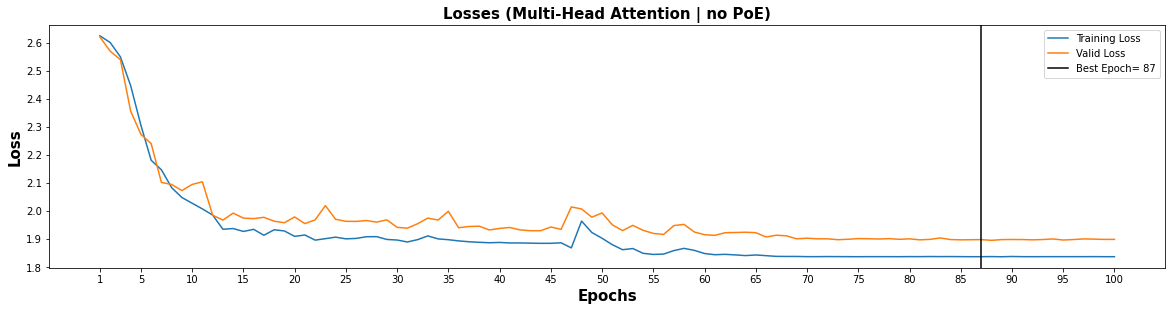

In [20]:
import matplotlib.pyplot as plt
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses)
axis.plot(x,valid_losses)
axis.axvline(best_epoch, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (Multi-Head Attention | no PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch}"]);

In [21]:
model1 = Transformer_Model(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model1.load_state_dict(torch.load('Multi_Att.pt'))

<All keys matched successfully>

In [22]:
pred,lab  = test(test_loader,model1)
time_point_acc = calc(pred,lab)

### Single-Head Attention

In [23]:
epochs     = 100
d_model    = 300
feed_fwd   = 128
output_dim = 15
n_head     = 1
n_layers   = 1
drop_prob  = 0.2
lr         = 0.001

In [24]:
model2  = Transformer_Model(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
criterion2 = nn.CrossEntropyLoss(ignore_index=-100)
model2

Transformer_Model(
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=128, bias=True)
        (l2): Linear(in_features=128, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  (linear_out): Linear(in_features=300

In [25]:
train_losses2,valid_losses2,best_epoch2 = train(epochs,train_loader,model2,valid_loader,optimizer2,criterion2,att_name="Single_Att")

Validation loss decreased (inf --> 2.588746).  Saving model ...
Epoch: 1/100 	Training Loss: 2.631753 	Validation Loss: 2.588746
Validation loss decreased (2.588746 --> 2.575422).  Saving model ...
Epoch: 2/100 	Training Loss: 2.584103 	Validation Loss: 2.575422
Validation loss decreased (2.575422 --> 2.476811).  Saving model ...
Epoch: 3/100 	Training Loss: 2.535889 	Validation Loss: 2.476811
Validation loss decreased (2.476811 --> 2.391491).  Saving model ...
Epoch: 4/100 	Training Loss: 2.450850 	Validation Loss: 2.391491
Validation loss decreased (2.391491 --> 2.235666).  Saving model ...
Epoch: 5/100 	Training Loss: 2.284369 	Validation Loss: 2.235666
Validation loss decreased (2.235666 --> 2.088505).  Saving model ...
Epoch: 6/100 	Training Loss: 2.133317 	Validation Loss: 2.088505
Validation loss decreased (2.088505 --> 2.047759).  Saving model ...
Epoch: 7/100 	Training Loss: 2.064413 	Validation Loss: 2.047759
Validation loss decreased (2.047759 --> 2.013366).  Saving model ..

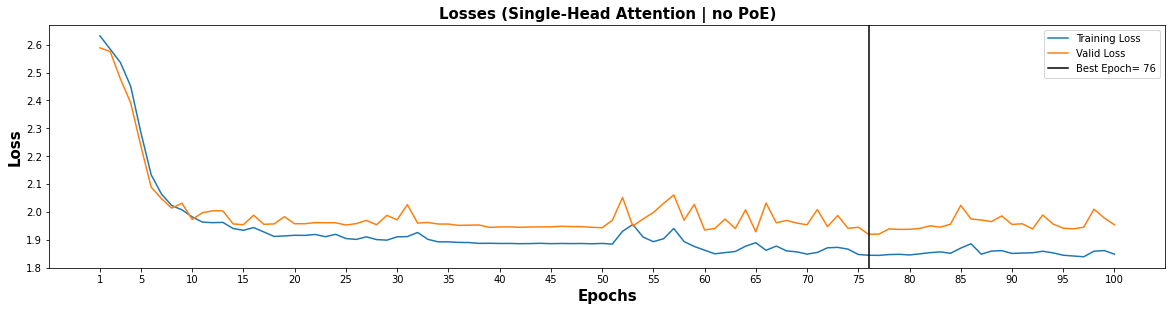

In [26]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses2)
axis.plot(x,valid_losses2)
axis.axvline(best_epoch2, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (Single-Head Attention | no PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch2}"]);

In [27]:
model2 = Transformer_Model(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model2.load_state_dict(torch.load('Single_Att.pt'))

<All keys matched successfully>

In [28]:
pred1,lab = test(test_loader,model2)
time_point_acc1 = calc(pred1,lab)

## Testing (No PoE)

### Multi-Head Attention

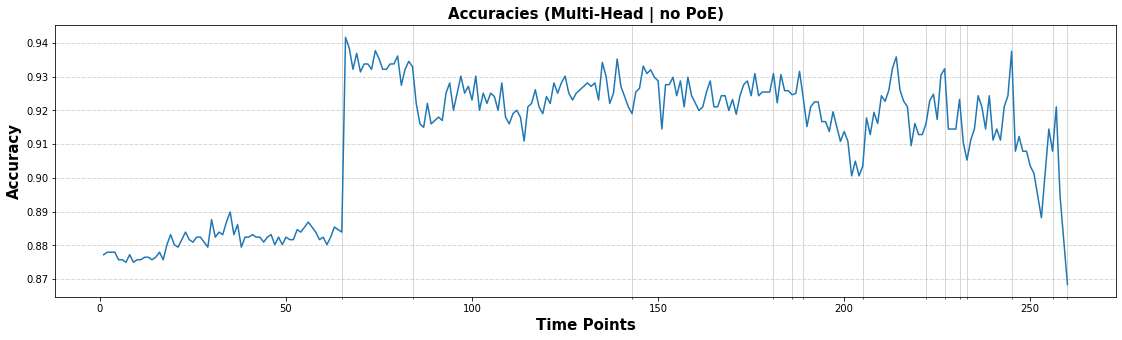

In [29]:
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (Multi-Head | no PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

### Single-Head Attention

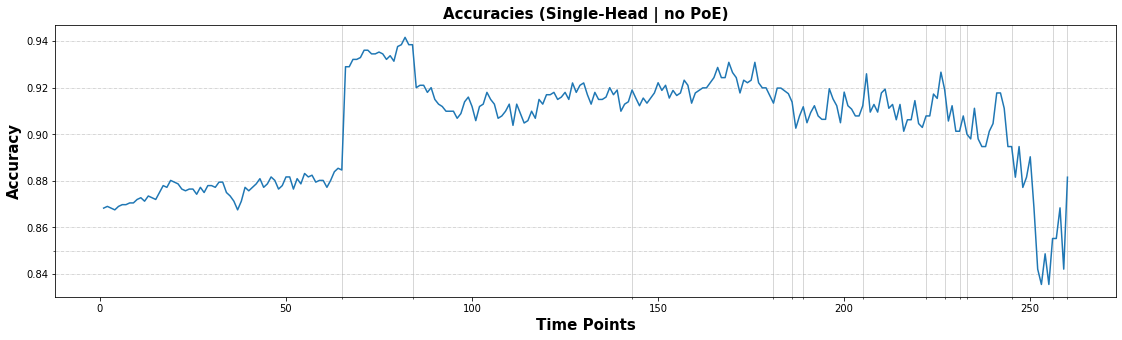

In [30]:
time = [i for i in range(1,seq_length+1)]
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc1)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (Single-Head | no PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

## Training (with PoE)

### Multi-Head Attention

In [31]:
epochs     = 100
d_model    = 300
feed_fwd   = 128
output_dim = 15
n_head     = 4
n_layers   = 1
drop_prob  = 0.2
lr         = 0.001

In [32]:
model3 = Transformer_Model_PoE(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr)
criterion3 = nn.CrossEntropyLoss(ignore_index=-100)
model3

Transformer_Model_PoE(
  (po_en): PositionalEncoding()
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=128, bias=True)
        (l2): Linear(in_features=128, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  

In [33]:
train_losses3,valid_losses3,best_epoch3 = train(epochs,train_loader,model3,valid_loader,optimizer3,criterion3,att_name="PoE_Multi_Att")

Validation loss decreased (inf --> 1.450326).  Saving model ...
Epoch: 1/100 	Training Loss: 1.984350 	Validation Loss: 1.450326
Validation loss decreased (1.450326 --> 0.898917).  Saving model ...
Epoch: 2/100 	Training Loss: 1.253709 	Validation Loss: 0.898917
Validation loss decreased (0.898917 --> 0.586386).  Saving model ...
Epoch: 3/100 	Training Loss: 0.760255 	Validation Loss: 0.586386
Validation loss decreased (0.586386 --> 0.301999).  Saving model ...
Epoch: 4/100 	Training Loss: 0.440664 	Validation Loss: 0.301999
Validation loss decreased (0.301999 --> 0.239972).  Saving model ...
Epoch: 5/100 	Training Loss: 0.306546 	Validation Loss: 0.239972
Validation loss decreased (0.239972 --> 0.217352).  Saving model ...
Epoch: 6/100 	Training Loss: 0.186200 	Validation Loss: 0.217352
Epoch: 7/100 	Training Loss: 0.142865 	Validation Loss: 0.291342
Validation loss decreased (0.217352 --> 0.159229).  Saving model ...
Epoch: 8/100 	Training Loss: 0.094281 	Validation Loss: 0.159229
Ep

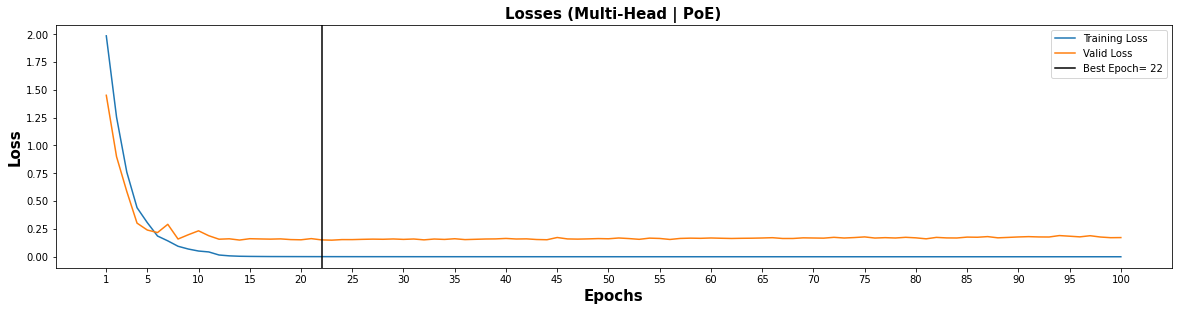

In [34]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses3)
axis.plot(x,valid_losses3)
axis.axvline(best_epoch3, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (Multi-Head | PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch3}"]);

In [35]:
model3 = Transformer_Model_PoE(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model3.load_state_dict(torch.load('PoE_Multi_Att.pt'))

<All keys matched successfully>

In [36]:
pred2,lab = test(test_loader,model3)
time_point_acc2 = calc(pred2,lab)

### Single-Head Attention

In [37]:
epochs     = 100
d_model    = 300
feed_fwd   = 128
output_dim = 15
n_head     = 1
n_layers   = 1
drop_prob  = 0.2
lr         = 0.001

In [38]:
model4  = Transformer_Model_PoE(d_model, feed_fwd, output_dim, n_layers,n_head, drop_prob)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=lr)
criterion4 = nn.CrossEntropyLoss(ignore_index=-100)
model4

Transformer_Model_PoE(
  (po_en): PositionalEncoding()
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (attention): Attention(
          (softmax): Softmax(dim=-1)
        )
        (w_q): Linear(in_features=300, out_features=300, bias=True)
        (w_k): Linear(in_features=300, out_features=300, bias=True)
        (w_v): Linear(in_features=300, out_features=300, bias=True)
        (w_concat): Linear(in_features=300, out_features=300, bias=True)
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (feed_fwd): FeedForward(
        (l1): Linear(in_features=300, out_features=128, bias=True)
        (l2): Linear(in_features=128, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (relu): ReLU()
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
    )
  )
  

In [39]:
train_losses4,valid_losses4,best_epoch4 = train(epochs,train_loader,model4,valid_loader,optimizer4,criterion4,att_name="PoE_Single_Att")

Validation loss decreased (inf --> 1.740302).  Saving model ...
Epoch: 1/100 	Training Loss: 2.318935 	Validation Loss: 1.740302
Validation loss decreased (1.740302 --> 0.830907).  Saving model ...
Epoch: 2/100 	Training Loss: 1.217529 	Validation Loss: 0.830907
Validation loss decreased (0.830907 --> 0.568354).  Saving model ...
Epoch: 3/100 	Training Loss: 0.665637 	Validation Loss: 0.568354
Validation loss decreased (0.568354 --> 0.410904).  Saving model ...
Epoch: 4/100 	Training Loss: 0.404095 	Validation Loss: 0.410904
Validation loss decreased (0.410904 --> 0.409496).  Saving model ...
Epoch: 5/100 	Training Loss: 0.276817 	Validation Loss: 0.409496
Validation loss decreased (0.409496 --> 0.337706).  Saving model ...
Epoch: 6/100 	Training Loss: 0.236948 	Validation Loss: 0.337706
Epoch: 7/100 	Training Loss: 0.197227 	Validation Loss: 0.348831
Epoch: 8/100 	Training Loss: 0.130887 	Validation Loss: 0.504173
Validation loss decreased (0.337706 --> 0.320143).  Saving model ...
Ep

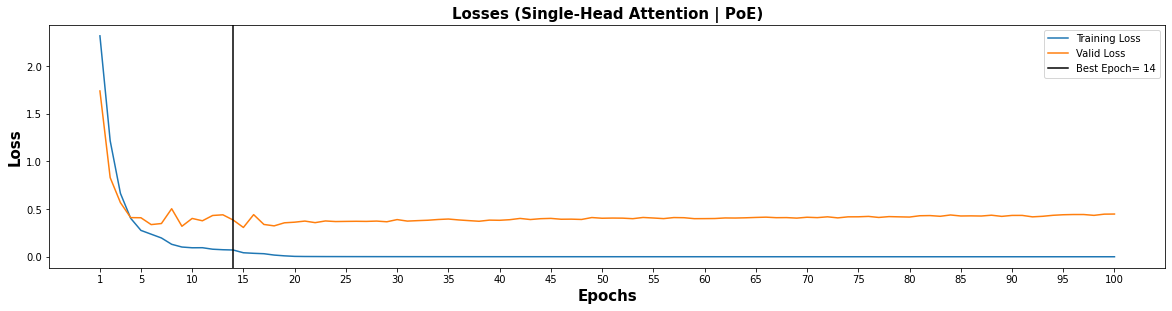

In [40]:
x     = [i for i in range(1,epochs+1)]
xi    = [i for i in range(0,epochs+5,5)]
xi[0] = 1
f, axis = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(5)
plt.subplots_adjust(top=0.8, wspace=0.2,hspace=0.3)

axis.plot(x,train_losses4)
axis.plot(x,valid_losses4)
axis.axvline(best_epoch4, color='black')
axis.set_xticks(xi)
axis.set_xlabel("Epochs",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_ylabel("Loss",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
axis.set_title("Losses (Single-Head Attention | PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center')
axis.legend(["Training Loss","Valid Loss",f"Best Epoch= {best_epoch4}"]);

In [41]:
model4 = Transformer_Model_PoE(d_model, feed_fwd, output_dim, n_layers, n_head, drop_prob)
model4.load_state_dict(torch.load('PoE_Single_Att.pt'))

<All keys matched successfully>

In [42]:
pred3,lab = test(test_loader,model4)
time_point_acc3 = calc(pred3,lab)

## Testing (with PoE)

### Multi-Head

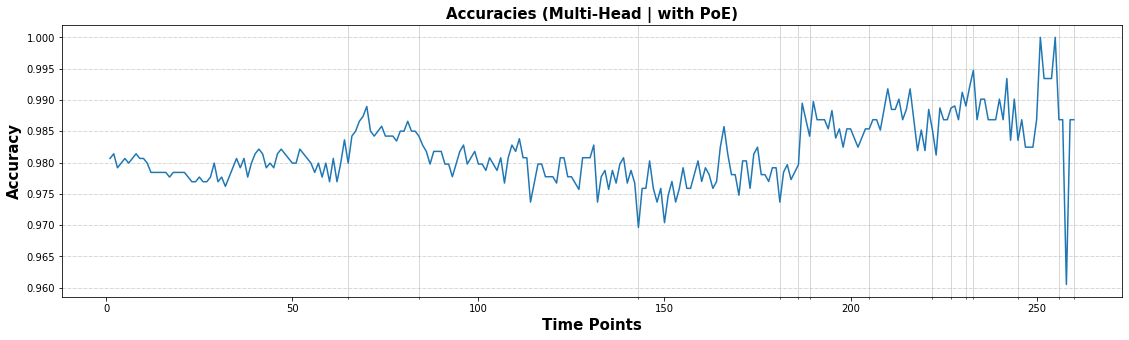

In [43]:
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc2)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (Multi-Head | with PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

### Single-Head

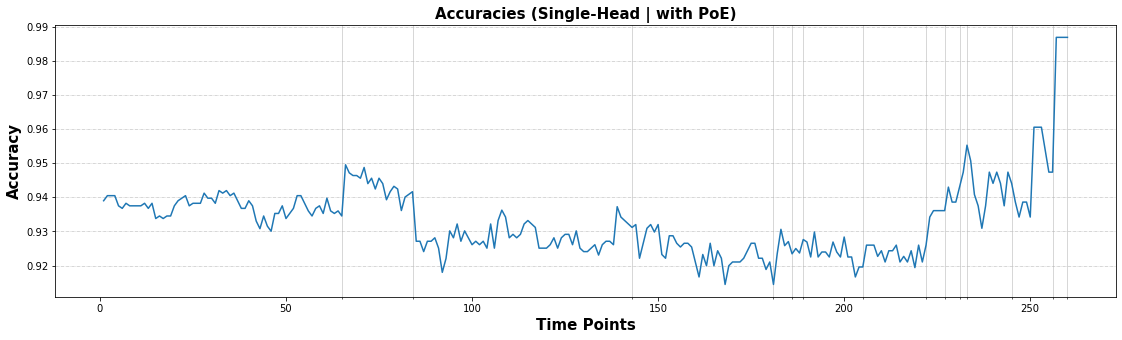

In [44]:
f, ax = plt.subplots(1,1)
f.set_figwidth(19)
f.set_figheight(5)
ax.plot(time,time_point_acc3)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Accuracies (Single-Head | with PoE)",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

## Comparison

### Transformer Models

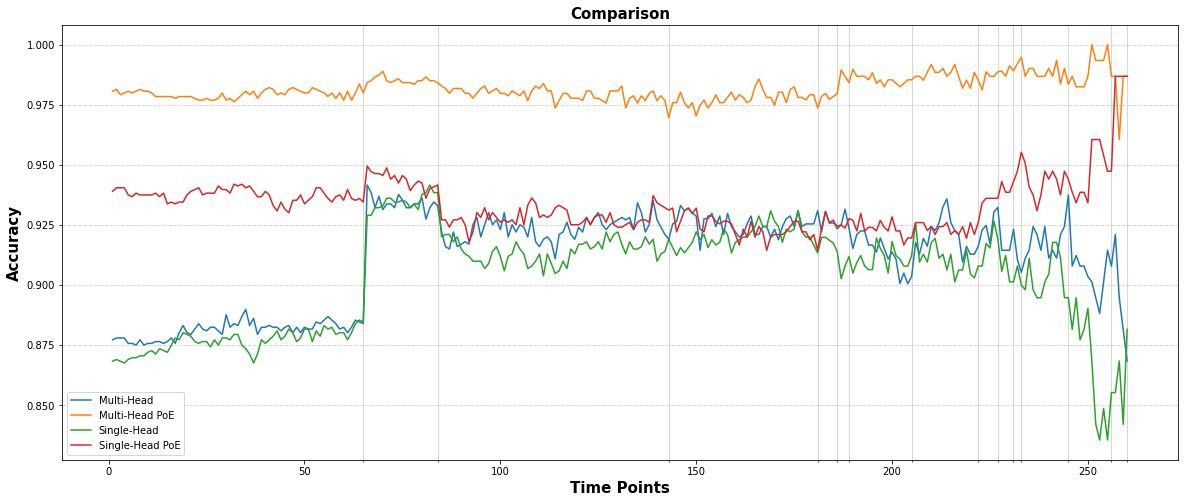

In [45]:
f, ax = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(8)
ax.plot(time,time_point_acc)
ax.plot(time,time_point_acc2)
ax.plot(time,time_point_acc1)
ax.plot(time,time_point_acc3)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.legend(["Multi-Head","Multi-Head PoE","Single-Head","Single-Head PoE"])
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("Comparison",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');

### All Models

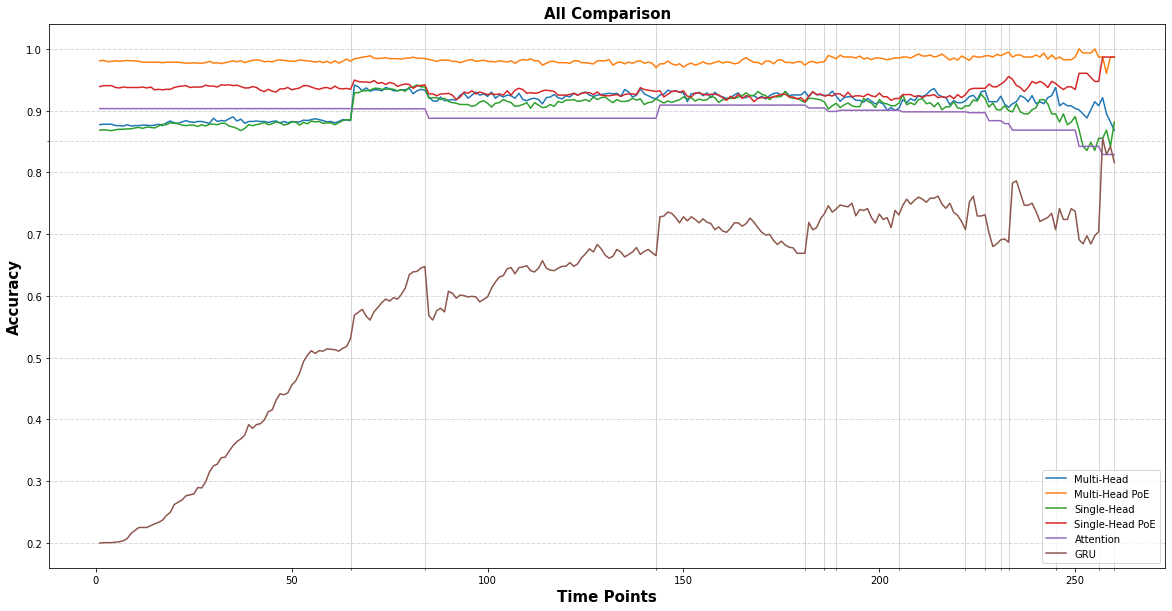

In [51]:
with open('acc.npy', 'rb') as f:
    att = np.load(f)
    gru = np.load(f)

f, ax = plt.subplots(1,1)
f.set_figwidth(20)
f.set_figheight(10)
ax.plot(time,time_point_acc)
ax.plot(time,time_point_acc2)
ax.plot(time,time_point_acc1)
ax.plot(time,time_point_acc3)
ax.plot(time,att)
ax.plot(time,gru)
ax.set_xticks(time_changes, minor=True)
ax.set_yticks([0.85], minor=True)
ax.yaxis.grid(True,linestyle='-.', linewidth=0.5, which='both')
ax.xaxis.grid(True,linestyle='-', linewidth=0.5, which='minor')
ax.legend(["Multi-Head","Multi-Head PoE","Single-Head","Single-Head PoE","Attention","GRU"])
ax.set_xlabel("Time Points",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_ylabel("Accuracy",fontweight="bold",color = 'Black', fontsize='15', horizontalalignment='center')
ax.set_title("All Comparison",fontweight='bold',color = 'Black', fontsize='15', horizontalalignment='center');